# Sheet 12

In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import MCMT
from operator import not_

## 1)

In [4]:
def get_base():
    qc = QuantumCircuit(7,name="state_prep")
    qc.cx(0,6)
    qc.cx(6,0)
    qc.barrier()
    qc.h([0,1,2])
    qc.barrier()
    qc.cx(6,[5,4])
    qc.barrier()
    qc.cx(0,[3,5,6])
    qc.barrier()
    qc.cx(1,[3,4,6])
    qc.barrier()
    qc.cx(2,[3,4,5])
    return qc.to_instruction()
def get_base_inverse():
    qc = QuantumCircuit(7,name="Comp. Basis")
    qc.cx(2,[3,4,5])
    qc.cx(1,[3,4,6])
    qc.cx(0,[3,5,6])
    qc.cx(6,[5,4])
    qc.h([0,1,2])
    qc.cx(6,0)
    qc.cx(0,6)
    return qc.to_instruction()

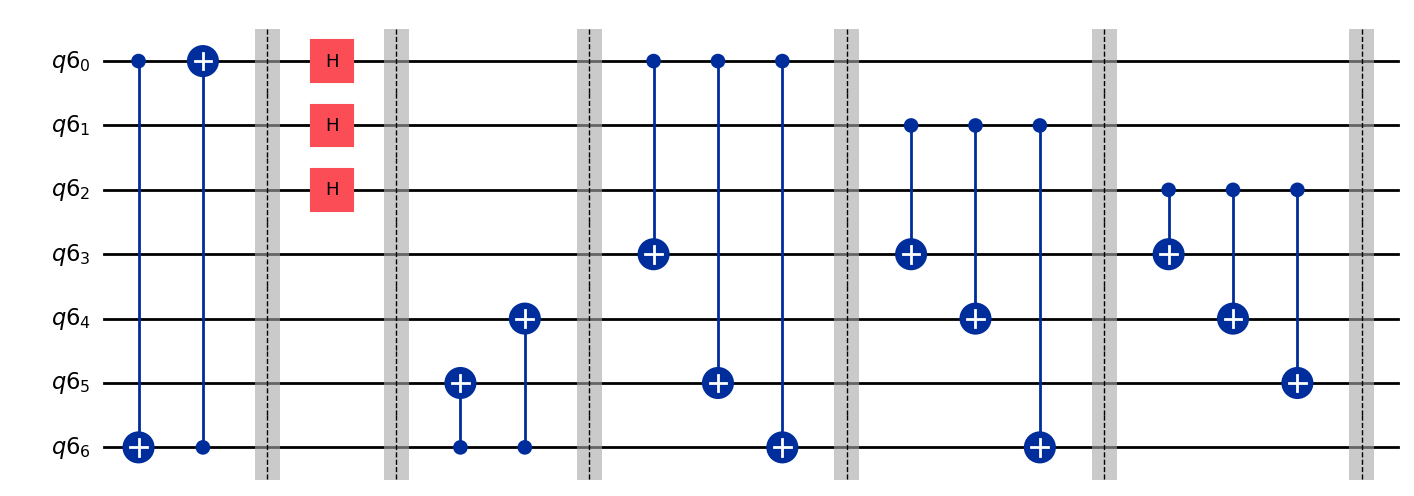

In [14]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)
# qc.x(0)
qc.append(get_base(),qr)

qc.barrier()
# qc.append(get_base_inverse(),qr)
qc.decompose().draw('mpl')

In [15]:
Statevector.from_instruction(qc).draw('latex')

<IPython.core.display.Latex object>

## 4)

To measure the stabilizers code from sheet 10 is reused. The PauliString libary form qiskit is used for convenience. The following notation is assumed $g=IXZZX = I_5 X_4 Z_3 Z_2 X_1$, where the subscript corresponds to the quibt the gate is applied on.
The addvantage to use X and Z is that they only nee a subset of 3 anchillas to detect bit/phase flip, which needs less gates.

In [27]:
def pauli_basetrafo(circuit,qubit_idx,pauli,qr,inverse=False):

    if pauli.x[qubit_idx]:
        if pauli.z[qubit_idx]:
            # Measure Y
            circuit.rx((-1*inverse + not_( inverse))*np.pi/2,qubit_idx)
        else:
            # Measure X
            circuit.h(qr[qubit_idx]) 
    return


In [28]:
def pauli_measurement(circuit, pauli, qr,anchilla, ):
    num_qubits = pauli.num_qubits
    for qubit_idx in range(num_qubits):
        if pauli[qubit_idx] == Pauli('I'):
            continue 
        pauli_basetrafo(circuit,qubit_idx,pauli,qr)
        circuit.cx(qubit_idx,anchilla)
        pauli_basetrafo(circuit,qubit_idx,pauli,qr,inverse=True)
    return circuit

In [29]:
def measure_multi_pauli(n_qubits,n,gs):
    qc = QuantumCircuit(n_qubits,name="pauli_measurement")
    qubits = list(range(n_qubits))
    qr = qubits[:n]
    a = qubits[n:]

    for i in range(len(gs)):
        pauli_measurement(qc, gs[i], qr,a[i]   )
    return qc.to_instruction()

Here are the stabilizers defined:

In [30]:
gs = [Pauli('IIIXXXX'),Pauli('IXXIIXX'),Pauli('XIXIXIX'),Pauli('IIIZZZZ'),Pauli('IZZIIZZ'),Pauli('ZIZIZIZ')]

In [31]:
sim = AerSimulator(method='statevector')

In [37]:
def get_random_error(qc,qr,gates=['X','Y','Z']):
    n = len(qr)
    qubit_to_apply_error = np.random.randint(n)
    operation = np.random.randint(len(gates))
    supported= {'X': qc.x,'Y': qc.y,'Z': qc.z}
    supported[gates[operation]](qubit_to_apply_error)
    return gates[operation],qubit_to_apply_error

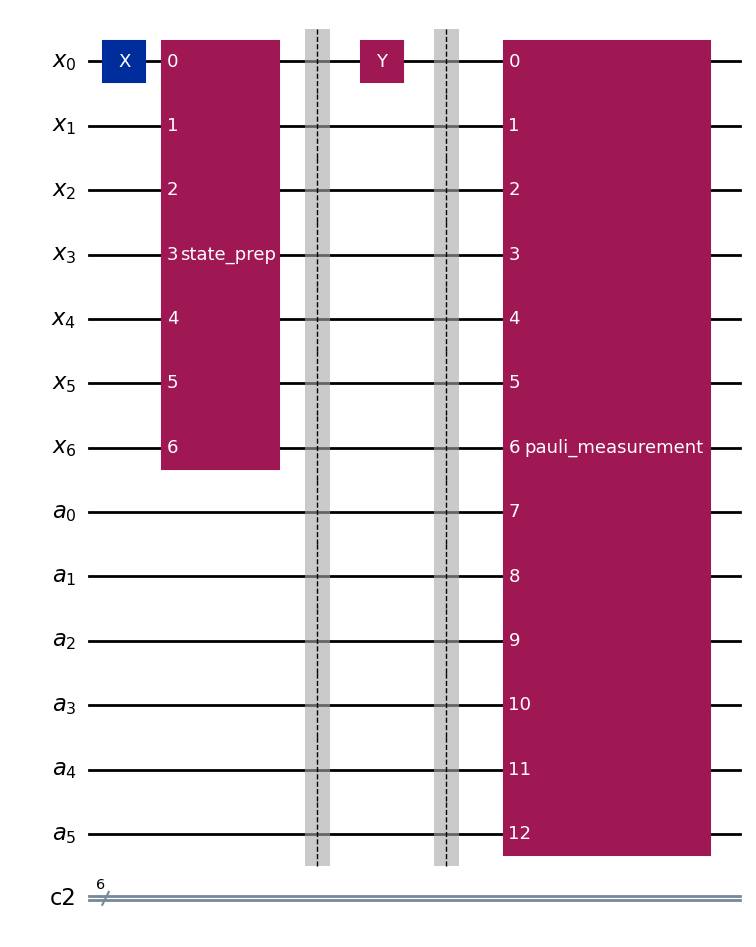

In [38]:
qr = QuantumRegister(7,'x')
a = QuantumRegister(6,'a')
cr = ClassicalRegister(6)
qc = QuantumCircuit(qr,a,cr)
pauli_measurment = measure_multi_pauli(7+6,7,gs)
qc.x(0)
qc.append(get_base(),qr)
qc.barrier()
error_pos = get_random_error(qc,qr,['X','Y','Z'])
qc.barrier()

qc.append(pauli_measurment,qr[:]+a[:])
qc.draw('mpl')
# Statevector.from_instruction(qc).draw('latex')


Now are the errors corrected. For now I assume that MCMT gates are allowed, and that the phase pick up from $Y = iXZ$ is irrelevant.

In [39]:
cx3 = MCMT('cx',3,1)
cy3 = MCMT('cy',3,1)
cz3 = MCMT('cz',3,1)


In [40]:
# x0 000111
qc.append(cx3,a[3:]+[qr[0]])

#x1 000110
qc.x(a[5])
qc.append(cx3,a[3:]+[qr[1]])
qc.x(a[5])
# x3 000101
qc.x(a[4])
qc.append(cx3,a[3:]+[qr[2]])
qc.x(a[4])
#x4 000100
qc.x(a[5])
qc.x(a[4])
qc.append(cx3,a[3:]+[qr[3]])
qc.x(a[5])
qc.x(a[4])
# x5 000011
qc.x(a[3])
qc.append(cx3,a[3:]+[qr[4]])
qc.x(a[3])
#x6 000010
qc.x(a[5])
qc.x(a[3])
qc.append(cx3,a[3:]+[qr[5]])
qc.x(a[5])
qc.x(a[3])
#x7 000001
qc.x(a[3])
qc.x(a[4])
qc.append(cx3,a[3:]+[qr[6]])
qc.x(a[3])
qc.x(a[4])

In [41]:
# for z 
# z0 111000
qc.append(cz3,a[0:3]+[qr[0]])

#z1 110000
qc.x(a[2])
qc.append(cz3,a[0:3]+[qr[1]])
qc.x(a[2])
# z3 101000
qc.x(a[1])
qc.append(cz3,a[0:3]+[qr[2]])
qc.x(a[1])
#z4 100
qc.x(a[2])
qc.x(a[1])
qc.append(cz3,a[0:3]+[qr[3]])
qc.x(a[2])
qc.x(a[1])
#z5 011
qc.x(a[0])
qc.append(cz3,a[0:3]+[qr[4]])
qc.x(a[0])
#z6 010
qc.x(a[0])
qc.x(a[2])
qc.append(cz3,a[0:3]+[qr[5]])
qc.x(a[0])
qc.x(a[2])
#z7 001
qc.x(a[0])
qc.x(a[1])
qc.append(cz3,a[0:3]+[qr[6]])
qc.x(a[0])
qc.x(a[1])

invert to computational basis

In [42]:

qc.append(get_base_inverse(),qr)

In [44]:
error_pos

('Y', 0)

In [43]:
Statevector.from_instruction(qc).draw('latex')

<IPython.core.display.Latex object>

We see that the error is shifted from our calculattion bits to our achillas. 